## Decoder Arch of the GPT

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_head": 12,
    "n_layers": 12, # Numbers of transformer block
    "drop_rate": 0.1,
    "qkv_bias": False
}

### How we will build the rest of the arch

![arch](/home/znyd/hacking/meow-former/images/decoder_arch.png)

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.4355, -0.2345, -0.4002,  ...,  0.8453, -0.0345,  0.0919],
         [ 0.2656,  0.1621, -0.4066,  ...,  0.8697, -0.3358, -0.8319],
         [ 1.1223, -0.6502,  0.4750,  ..., -0.7017, -1.0961,  0.7150],
         [ 0.4153, -0.2304, -0.7610,  ...,  0.3562, -0.2664,  0.0980]],

        [[ 0.2855,  0.0187, -0.0450,  ...,  0.7994, -0.7919,  0.3502],
         [ 0.7271,  0.9928,  0.8565,  ..., -0.5928, -0.3715, -0.2204],
         [ 0.8889,  0.1886, -0.1988,  ..., -0.8789, -0.9408,  1.4522],
         [-1.4786,  0.9579, -0.4698,  ..., -0.4789,  0.5454, -0.9905]]],
       grad_fn=<UnsafeViewBackward0>)


### Layer Normalization

<h4>
Making the layer outputs mean = 0 and variance = 1
</h4>

In [5]:
btch = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()) 
out = layer(btch)
print(out)

tensor([[0.0000, 0.0000, 1.2543, 0.9829, 0.4117, 0.4563],
        [0.0000, 0.5161, 0.7221, 0.0000, 0.6295, 0.0000]],
       grad_fn=<ReluBackward0>)


In [6]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f"Mean: {mean}")
print(f"Variance: {var}")

Mean: tensor([[0.5175],
        [0.3113]], grad_fn=<MeanBackward1>)
Variance: tensor([[0.2620],
        [0.1205]], grad_fn=<VarBackward0>)


In [10]:
out_norm = (out - mean) / torch.sqrt(var)
mean_a = out_norm.mean(dim=-1, keepdim=True)
var_a = out_norm.var(dim=-1, keepdim=True)
torch.set_printoptions(sci_mode=False)
print(mean_a)
print(var_a)

tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [13]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift= nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var+self.eps)
        return self.scale * norm_x + self.shift


In [14]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(btch)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### GELU and FFN

In [22]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 + torch.pow(x, 3))))

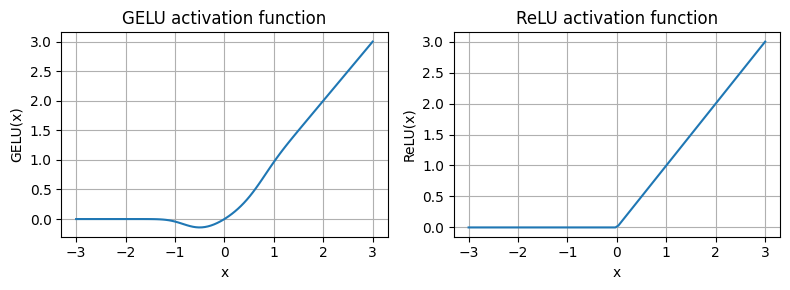

In [23]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

#### Simple Feed Forward

![ffn](/home/znyd/hacking/meow-former/images/ffn.png)

In [33]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
    )

    def forward(self, x):
        return self.layers(x)

In [34]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])
